<a href="https://colab.research.google.com/github/ChanglinWu/DL/blob/main/YOLOv8_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE5438 Applied Deep Learning

# **YOLOv8 Colab Demo**

YOLOV8 is the latest edition of popular YOLO algorithm specifically designed for industry applications. It achieves high mAP with amazing fps.

We will be implementing the following steps:

1. Install YOLOv8 from Ultralytics
2. Running inference on single **image**.
3. YOLOVv8 Image Segmentation and Human Pose Estimation
4. Download sample **video** and run YOLOv8 inference on it.
5. YOLOv8 Webcam demo.

References:
- https://www.youtube.com/watch?v=75LI9MI9eEo

## Install YOLOv8 from Ultralytics

In [ ]:
!pip install ultralytics -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.7/877.7 kB 13.5 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import torch
from IPython.display import display, Image
device = 'cuda' if torch.cuda.is_available() else "cpu"

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## YOLOv2 Object Detection on Image

In [ ]:
# Download a test image
!wget https://www.ee.cityu.edu.hk/~lmpo/ee5438/images/person.png

--2024-10-30 08:38:19--  https://www.ee.cityu.edu.hk/~lmpo/ee5438/images/person.png
Resolving www.ee.cityu.edu.hk (www.ee.cityu.edu.hk)... 144.214.130.190
Connecting to www.ee.cityu.edu.hk (www.ee.cityu.edu.hk)|144.214.130.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 464955 (454K) [image/png]
Saving to: ‘person.png’

person.png          100%[===================>] 454.06K   723KB/s    in 0.6s    

2024-10-30 08:38:21 (723 KB/s) - ‘person.png’ saved [464955/464955]



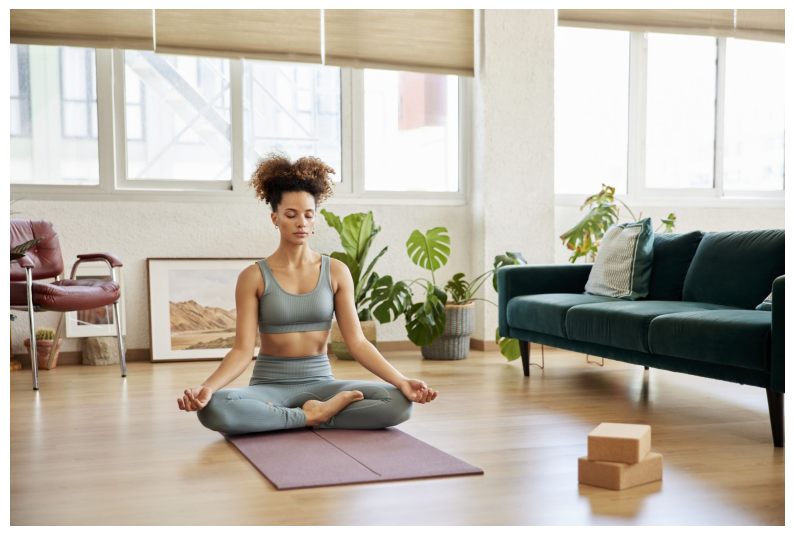

In [ ]:
Image(filename='/content/person.png', height=500)

In [ ]:
!rm -rf /content/runs
!yolo task=detect mode=predict model=yolov8s.pt conf=0.5 source='/content/person.png' save=True

100% 21.5M/21.5M [00:00<00:00, 60.7MB/s]
Ultralytics 8.3.24 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs

image 1/1 /content/person.png: 448x640 1 person, 1 couch, 2 potted plants, 64.4ms
Speed: 10.6ms preprocess, 64.4ms inference, 1227.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
Image(filename='/content/runs/detect/predict/person.png', height=500)

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/predict/person.png'

## YOLOv8 Instance Segmentation

In [ ]:
!rm -rf /content/runs
!yolo task=segment mode=predict model=yolov8m-seg.pt conf=0.5 source='/content/person.png' save=True

In [ ]:
Image(filename='/content/runs/segment/predict/person.png', height=500)

## YOLOv8 Human Pose Estimation

In [ ]:
!rm -rf /content/runs
!yolo task=pose mode=predict model=yolov8s-pose.pt conf=0.5 source='/content/person.png' save=True

In [ ]:
Image(filename='/content/runs/pose/predict/person.png', height=500)

## YOLOv8 Object Detection on Video

In [ ]:
# Download a video from Internet
!gdown --fuzzy https://drive.google.com/uc?id=1eTD-V5A1-ZGS3Rr-syip8kdZfWKRXHDP
video_path = '/content/test2.mp4'

In [ ]:
!rm -rf /content/runs
!yolo task=detect mode=predict model=yolov8n.pt conf=0.5 source='/content/test2.mp4' save=True

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/runs/detect/predict/test2.avi'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

 # **Inference on webcam**

### Webcam Helper Functions

In [ ]:
from ultralytics import YOLO
import torch
import numpy as np

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import PIL
import io
import html
import cv2

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)

In [ ]:
def plot_boxes(image, boxes, labels=[], colors=[], score=True, conf=None):
  #Define COCO Labels
  if labels == []:
    labels = {0: u'__background__', 1: u'person', 2: u'bicycle',3: u'car', 4: u'motorcycle', 5: u'airplane', 6: u'bus', 7: u'train', 8: u'truck', 9: u'boat', 10: u'traffic light', 11: u'fire hydrant', 12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird', 16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep', 20: u'cow', 21: u'elephant', 22: u'bear', 23: u'zebra', 24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag', 28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis', 32: u'snowboard', 33: u'sports ball', 34: u'kite', 35: u'baseball bat', 36: u'baseball glove', 37: u'skateboard', 38: u'surfboard', 39: u'tennis racket', 40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork', 44: u'knife', 45: u'spoon', 46: u'bowl', 47: u'banana', 48: u'apple', 49: u'sandwich', 50: u'orange', 51: u'broccoli', 52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut', 56: u'cake', 57: u'chair', 58: u'couch', 59: u'potted plant', 60: u'bed', 61: u'dining table', 62: u'toilet', 63: u'tv', 64: u'laptop', 65: u'mouse', 66: u'remote', 67: u'keyboard', 68: u'cell phone', 69: u'microwave', 70: u'oven', 71: u'toaster', 72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock', 76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier', 80: u'toothbrush'}
  #Define colors
  if colors == []:
    #colors = [(6, 112, 83), (253, 246, 160), (40, 132, 70), (205, 97, 162), (149, 196, 30), (106, 19, 161), (127, 175, 225), (115, 133, 176), (83, 156, 8), (182, 29, 77), (180, 11, 251), (31, 12, 123), (23, 6, 115), (167, 34, 31), (176, 216, 69), (110, 229, 222), (72, 183, 159), (90, 168, 209), (195, 4, 209), (135, 236, 21), (62, 209, 199), (87, 1, 70), (75, 40, 168), (121, 90, 126), (11, 86, 86), (40, 218, 53), (234, 76, 20), (129, 174, 192), (13, 18, 254), (45, 183, 149), (77, 234, 120), (182, 83, 207), (172, 138, 252), (201, 7, 159), (147, 240, 17), (134, 19, 233), (202, 61, 206), (177, 253, 26), (10, 139, 17), (130, 148, 106), (174, 197, 128), (106, 59, 168), (124, 180, 83), (78, 169, 4), (26, 79, 176), (185, 149, 150), (165, 253, 206), (220, 87, 0), (72, 22, 226), (64, 174, 4), (245, 131, 96), (35, 217, 142), (89, 86, 32), (80, 56, 196), (222, 136, 159), (145, 6, 219), (143, 132, 162), (175, 97, 221), (72, 3, 79), (196, 184, 237), (18, 210, 116), (8, 185, 81), (99, 181, 254), (9, 127, 123), (140, 94, 215), (39, 229, 121), (230, 51, 96), (84, 225, 33), (218, 202, 139), (129, 223, 182), (167, 46, 157), (15, 252, 5), (128, 103, 203), (197, 223, 199), (19, 238, 181), (64, 142, 167), (12, 203, 242), (69, 21, 41), (177, 184, 2), (35, 97, 56), (241, 22, 161)]
    colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]

  #plot each boxes
  for box in boxes:
    #add score in label if score=True
    if score :
      label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
    else :
      label = labels[int(box[-1])+1]
    #filter every box under conf threshold if conf threshold setted
    if conf :
      if box[-2] > conf:
        color = colors[int(box[-1])]
        box_label(image, box, label, color)
    else:
      color = colors[int(box[-1])]
      box_label(image, box, label, color)

  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  return image

In [ ]:
from IPython.display import clear_output

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = YOLO("yolov8n.pt").to(device)

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  img0 = js_to_image(js_reply["img"])
  image = np.asarray(img0)
  bbox_array = np.zeros([image.shape[0],image.shape[1],4], dtype = np.uint8)

  # Inference
  results = model(image, verbose=False)
  #clear the last prediction output
  clear_output(wait = True)

  bboxes = (results[0].boxes.data).cpu().numpy()
  bbox_array = plot_boxes(bbox_array, bboxes, score = True)
  bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0).astype(int) * 255
  bbox_bytes = bbox_to_bytes(bbox_array)

  bbox = bbox_bytes